<a href="https://colab.research.google.com/github/chathura-de-silva/Pattern-Recognition/blob/main/CNNs/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import struct
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50, DenseNet121
import gc

Loading the dataset, Normalizing images, shuffling and resplitting for training, testing and validation.

In [2]:
def load_images(filename):
    with open(filename, 'rb') as f:
        magic, image_count, rowls, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape((image_count, rowls, cols,1)) # Last dimension is to be compatiable with tensorflow Conv2D input.
        data = data.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return data

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, label_count = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def train_test_validation_split(X, Y, random_state,test_ratio=0.15, val_ratio=0.15):
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_ratio, random_state=random_state, stratify=Y)
    val_fraction_temp = val_ratio / (1 - test_ratio)  # Adjust validation size relative to the remaining data
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_fraction_temp, random_state=random_state, stratify=Y_temp) # This is done without using mode.fit()s validation split because it's not stratified.
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

# Loading with original split with a reshape.
try:
    init_train_images = load_images('/content/train-images.idx3-ubyte')
    init_train_labels = load_labels('/content/train-labels.idx1-ubyte')
    init_test_images = load_images('/content/t10k-images.idx3-ubyte')
    init_test_labels = load_labels('/content/t10k-labels.idx1-ubyte')
except Exception as e:
    print("Error loading data. Make sure the data files are present inside a 'dataset' folder with their original names:", e)

# Concatanation before shuffling and resplitting.

X = np.concatenate([init_train_images, init_test_images])
Y = np.concatenate([init_train_labels, init_test_labels])

# Randomisation seed for reproducibility
random_state = 42

# Shuffle and split.
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validation_split(X, Y,random_state)

print(f"Training  Set: {x_train.shape}, {y_train.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")
print(f"Validation Set: {x_val.shape}, {y_val.shape}")

Training  Set: (49000, 28, 28, 1), (49000,)
Test set: (10500, 28, 28, 1), (10500,)
Validation Set: (10500, 28, 28, 1), (10500,)


Neural Network Architecture

In [3]:
def get_model():
    model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])
    return model

model = get_model()

Learning Rate, Loss Function and Optimiser Specifications

In [4]:
learning_rate = 0.0005

adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Learning and early stopping criterion.

In [5]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.0001)

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512,  callbacks=[early_stopping])

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6213 - loss: 1.3433 - val_accuracy: 0.9332 - val_loss: 0.2227
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9319 - loss: 0.2353 - val_accuracy: 0.9629 - val_loss: 0.1202
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9602 - loss: 0.1363 - val_accuracy: 0.9715 - val_loss: 0.0906
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9703 - loss: 0.1026 - val_accuracy: 0.9760 - val_loss: 0.0726
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9744 - loss: 0.0848 - val_accuracy: 0.9810 - val_loss: 0.0602
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9785 - loss: 0.0714 - val_accuracy: 0.9817 - val_loss: 0.0555
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9806 - loss: 0.0635 - val_accuracy: 0.9836 - val_loss: 0.0487
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9827 - loss: 0.0561 - val_accuracy: 0.9850 - v

Model Evaluation and Performance metrics

In [6]:
#performance metrics (accuracy/precision/recall and F1)
def get_performance_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted',zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    return accuracy, precision, recall, f1

def plot_learning_loss_progression(history):
    plt.figure(figsize=(10, 6))

    # Plot training & validation loss
    epochs = range(1, len(history.history['loss']) + 1)

    plt.plot(epochs, history.history['loss'], label='Training Loss', linestyle='-', marker='o', color='black')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o', color='red')

    plt.title('Training & Validation Loss Variation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # making grid and axis more detailed.
    plt.xticks(np.arange(0, len(history.history['loss'])+1, 1))  # one tick per epoch
    plt.yticks(np.linspace(min(history.history['val_loss']),
                        max(history.history['loss']), 20))  # 20 y-ticks between min & max
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth=0.8, color='gray')
    plt.grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')

    # Legend
    plt.legend()
    plt.show()

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9898095238095238
Precision: 0.9898191861225305
Recall: 0.9898095238095238
F1-score: 0.9898041812975938


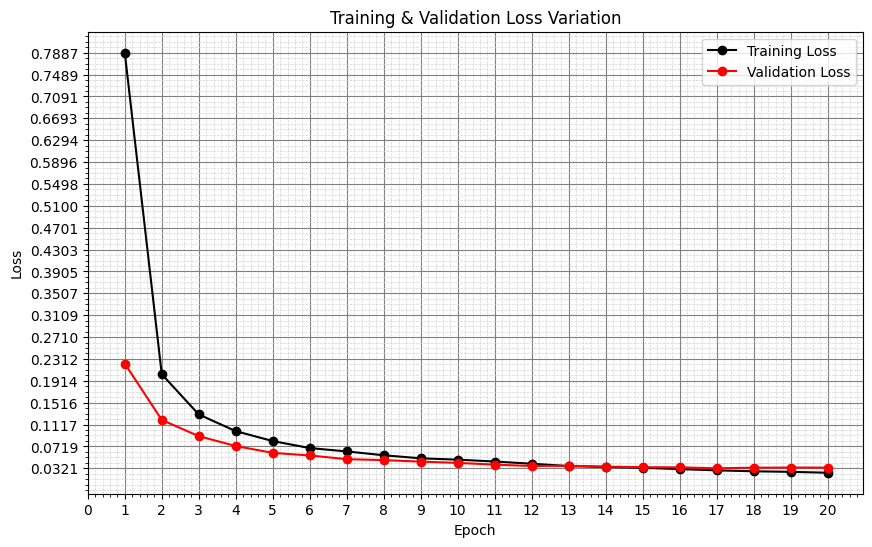

In [7]:
# evaluation on the test set.
y_pred = model.predict(x_test).argmax(axis=1)
performance = get_performance_metrics(y_test, y_pred)
plot_learning_loss_progression(history)

#### Training and evaluation of the model with SGD and SGD with momentum for comparision
 SGD - Training

In [8]:

model_sgd = get_model() # Reinitialize the model
sgd = keras.optimizers.SGD(learning_rate=learning_rate)
model_sgd.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sgd_history = model_sgd.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.1059 - loss: 2.2982 - val_accuracy: 0.1022 - val_loss: 2.2929
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1081 - loss: 2.2928 - val_accuracy: 0.1023 - val_loss: 2.2881
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1096 - loss: 2.2881 - val_accuracy: 0.1025 - val_loss: 2.2835
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1139 - loss: 2.2835 - val_accuracy: 0.1030 - val_loss: 2.2789
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1175 - loss: 2.2792 - val_accuracy: 0.1041 - val_loss: 2.2744
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1220 - loss: 2.2740 - val_accuracy: 0.1051 - val_loss: 2.2699
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1233 - loss: 2.2709 - val_accuracy: 0.1059 - val_loss: 2.2654
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1308 - loss: 2.2643 - val_accuracy: 0.1084 - v

SGD - Evaluation & Performance Metrics

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.212
Precision: 0.5095429932137648
Recall: 0.212
F1-score: 0.1859117930578323


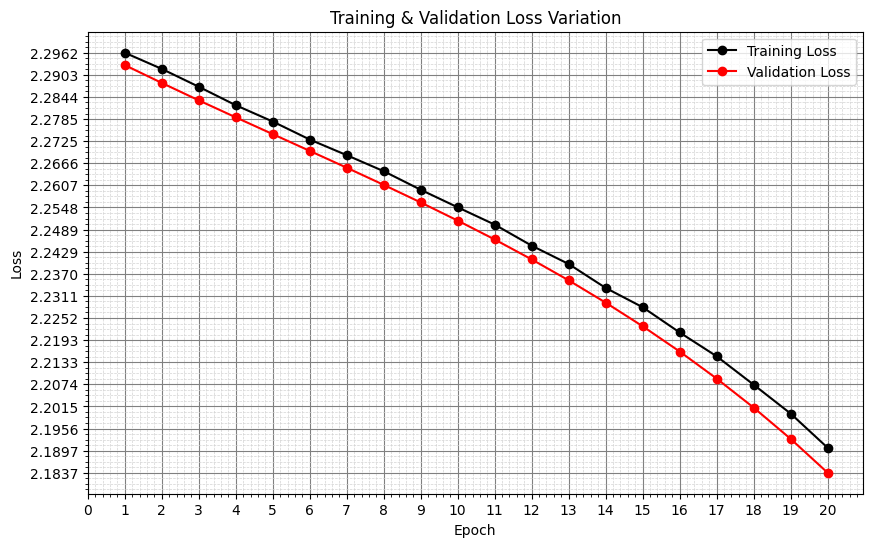

In [9]:
y_pred_sgd = model_sgd.predict(x_test).argmax(axis=1)
sgd_performance = get_performance_metrics(y_test, y_pred_sgd)
plot_learning_loss_progression(sgd_history)

SGD+Momentum - Training

In [10]:
model_sgdm = get_model() # Reinitialize the model
sgd_momentum = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_sgdm.compile(optimizer=sgd_momentum,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
sgdm_history = model_sgdm.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.1076 - loss: 2.2935 - val_accuracy: 0.1852 - val_loss: 2.2408
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2335 - loss: 2.2218 - val_accuracy: 0.4417 - val_loss: 2.1437
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4032 - loss: 2.1070 - val_accuracy: 0.6471 - val_loss: 1.9306
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5475 - loss: 1.8514 - val_accuracy: 0.7506 - val_loss: 1.4757
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6417 - loss: 1.4091 - val_accuracy: 0.7953 - val_loss: 0.9708
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7182 - loss: 1.0004 - val_accuracy: 0.8301 - val_loss: 0.6965
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7688 - loss: 0.7741 - val_accuracy: 0.8526 - val_loss: 0.5627
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8058 - loss: 0.6537 - val_accuracy: 0.8670 - v

SGD+Momentum - Evaluation & Performance Metrics

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9240952380952381
Precision: 0.9241866981740217
Recall: 0.9240952380952381
F1-score: 0.9240507208101562


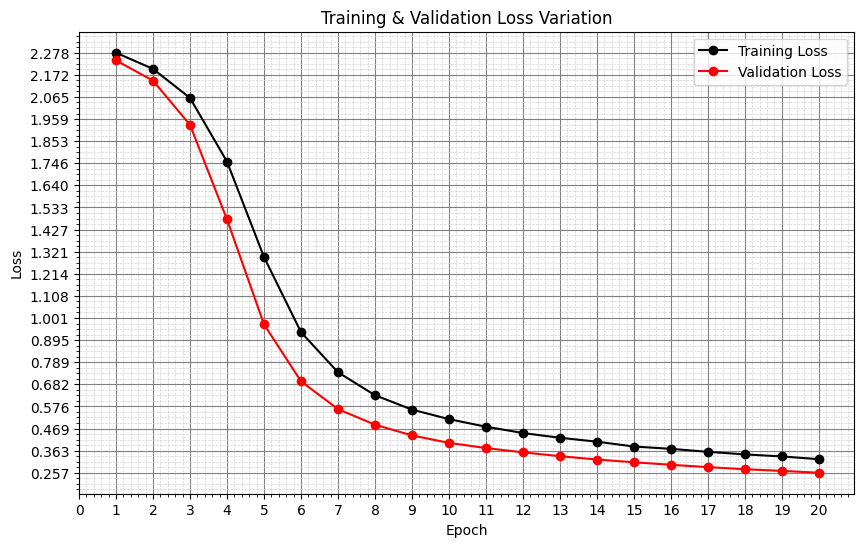

In [11]:
y_pred_sgdm = model_sgdm.predict(x_test).argmax(axis=1)
sgdm_performance = get_performance_metrics(y_test, y_pred_sgdm)

plot_learning_loss_progression(sgdm_history)

Performance Metrics Comparision Plot

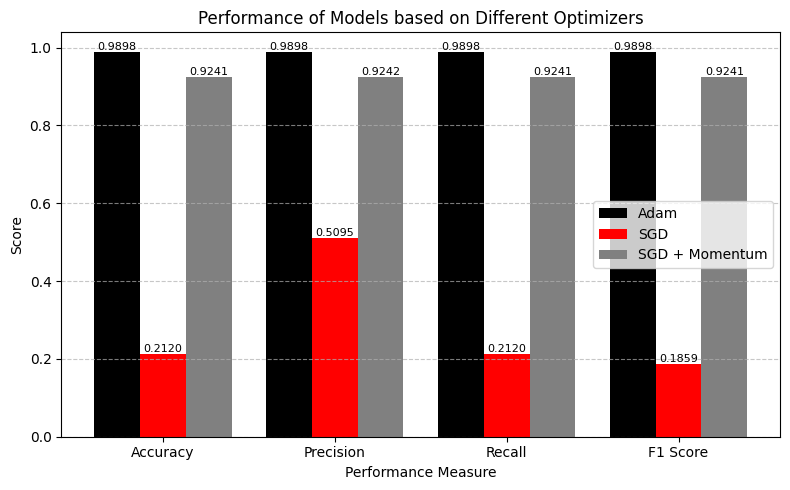

In [12]:
def plot_optimizer_performance(performance_lists, labels,  title="Performance of Models based on Different Optimizers"):

    conditions = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    x = np.arange(len(conditions))
    n = len(performance_lists)
    width = 0.8 / n  # total width divided among all bars

    colors = ['black', 'red', 'gray', 'blue', 'green', 'purple', 'orange']
    if (len(colors)<n):
      print(f"Only {len(colors)} different optimisers supported!")
      return
    plt.figure(figsize=(8, 5))

    for i, perf in enumerate(performance_lists):
        offset = (i - (n - 1) / 2) * width
        bars = plt.bar(x + offset, perf, width, label=labels[i], color=colors[i % len(colors)])
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                     f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

    plt.xlabel('Performance Measure')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, conditions)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_optimizer_performance([performance,sgd_performance,sgdm_performance],['Adam','SGD','SGD + Momentum'])

Confusion Matrices

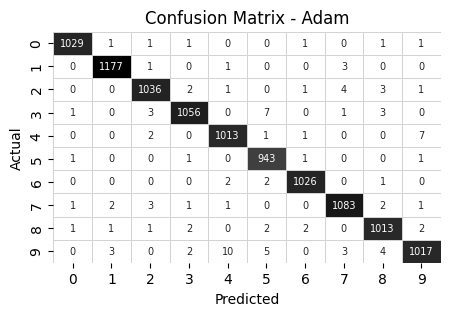

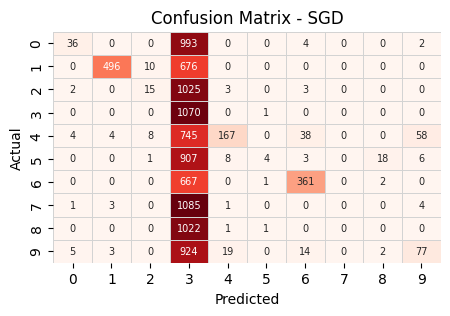

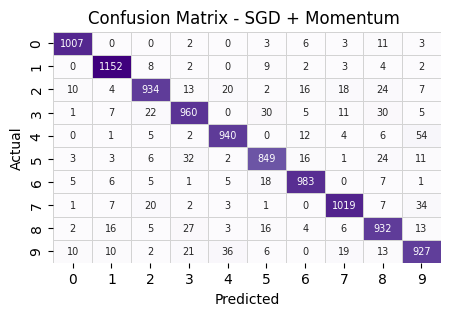

In [13]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', cmap='Blues'):
    cm = tf.math.confusion_matrix(y_true, y_pred).numpy()
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, linewidths=0.5, linecolor='lightgray', cbar=False, annot_kws={"size": 7})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    return

plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix - Adam', cmap='Greys')
plot_confusion_matrix(y_test, y_pred_sgd, title='Confusion Matrix - SGD', cmap='Reds')
plot_confusion_matrix(y_test, y_pred_sgdm, title='Confusion Matrix - SGD + Momentum ', cmap='Purples')

### Comparision With State of The Art Models

##### Selected Models

1. DenseNet(121)
2. ResNet(18)


#### DenseNet121

In [14]:
def add_classifier_to_base(base_model):
    model = keras.Sequential([
    base_model,                        # pretrained feature extractor
    layers.GlobalAveragePooling2D(),   # convert 3D features to 1D vector
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
    return model

base_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_densenet.trainable = False # freeze the convolutional base for use as feature extractor.

densenet_model = add_classifier_to_base(base_densenet)
adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
densenet_model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
def preprocess_fn(x, y, model_family):
    x = tf.image.resize(x, (64, 64))
    x = tf.image.grayscale_to_rgb(x)
    if model_family == 'ResNet':
        x = tf.keras.applications.resnet.preprocess_input(x)
    elif model_family == 'DenseNet':
        x = tf.keras.applications.densenet.preprocess_input(x)
    else:
        raise ValueError("Unsupported model family. Choose 'ResNet' or 'DenseNet'.")

    return x, y


def make_dataset(X, y, model_family, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(
        lambda x, y: preprocess_fn(x, y, model_family),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [16]:
train_ds = make_dataset(x_train, y_train, 'DenseNet')
val_ds = make_dataset(x_val, y_val, 'DenseNet')
test_ds = make_dataset(x_test, y_test, 'DenseNet')


In [17]:
densenet_history = densenet_model.fit(train_ds, validation_data=val_ds, epochs=20,callbacks=[early_stopping] )


Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 94s 45ms/step - accuracy: 0.6702 - loss: 1.0650 - val_accuracy: 0.9156 - val_loss: 0.2808
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9062 - loss: 0.3135 - val_accuracy: 0.9463 - val_loss: 0.1818
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9268 - loss: 0.2387 - val_accuracy: 0.9500 - val_loss: 0.1605
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9340 - loss: 0.2118 - val_accuracy: 0.9592 - val_loss: 0.1297
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9412 - loss: 0.1855 - val_accuracy: 0.9620 - val_loss: 0.1238
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9447 - loss: 0.1715 - val_accuracy: 0.9643 - val_loss: 0.1135
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9468 - loss: 0.1649 - val_accuracy: 0.9644 - val_loss: 0.1118
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9512 -

329/329 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step
Accuracy: 0.9721904761904762
Precision: 0.972375405368563
Recall: 0.9721904761904762
F1-score: 0.9722303864072315


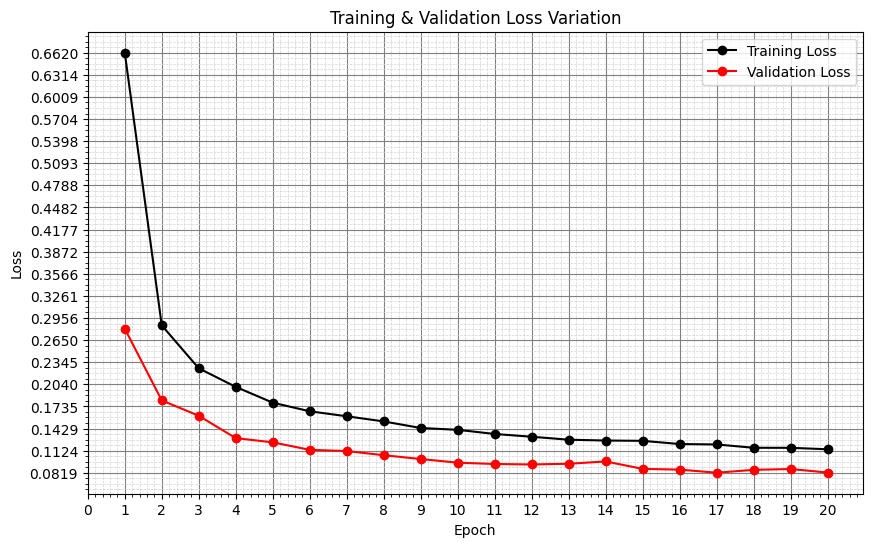

In [18]:

def model_performance_with_prefetch_data_obj(test_set):
  y_pred = densenet_model.predict(test_set)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = np.concatenate([y.numpy() for _, y in test_set], axis=0)
  return get_performance_metrics(y_true, y_pred)

densenet_performance = model_performance_with_prefetch_data_obj(test_ds)
plot_learning_loss_progression(densenet_history)

#### ResNet50

In [19]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_resnet.trainable = False # freeze the convolutional base for use as feature extractor.

resnet_model = add_classifier_to_base(base_resnet)
adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
resnet_model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
train_rn = make_dataset(x_train, y_train, 'ResNet')
val_rn = make_dataset(x_val, y_val, 'ResNet')
test_rn = make_dataset(x_test, y_test, 'ResNet')

In [21]:
resnet_history = resnet_model.fit(train_rn, validation_data=val_rn, epochs=20, callbacks=[early_stopping])

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 59s 27ms/step - accuracy: 0.5911 - loss: 1.2855 - val_accuracy: 0.8931 - val_loss: 0.3890
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8678 - loss: 0.4393 - val_accuracy: 0.9221 - val_loss: 0.2717
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8988 - loss: 0.3316 - val_accuracy: 0.9316 - val_loss: 0.2171
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9109 - loss: 0.2872 - val_accuracy: 0.9373 - val_loss: 0.2034
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9192 - loss: 0.2575 - val_accuracy: 0.9377 - val_loss: 0.1971
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9240 - loss: 0.2396 - val_accuracy: 0.9406 - val_loss: 0.1874
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9296 - loss: 0.2247 - val_accuracy: 0.9464 - val_loss: 0.1758
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9319 -

329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
Accuracy: 0.09857142857142857
Precision: 0.009716326530612244
Recall: 0.09857142857142857
F1-score: 0.01768902099201189


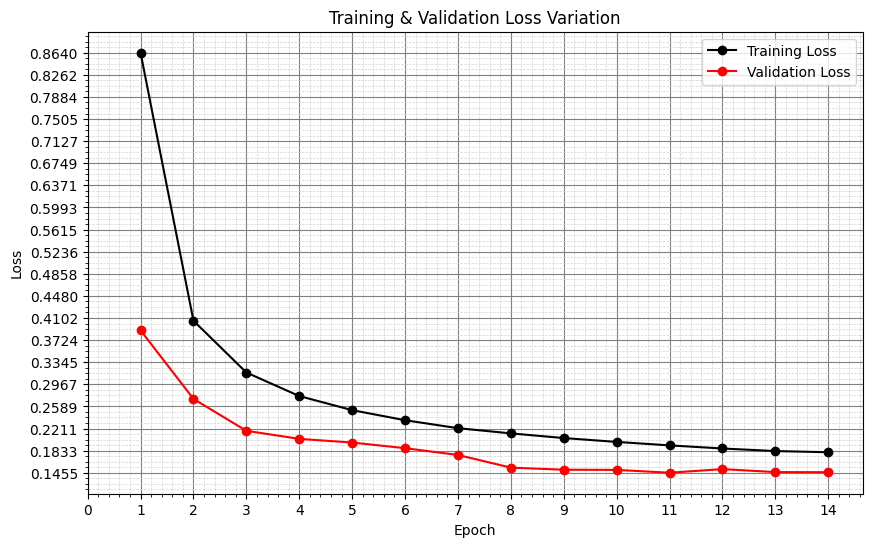

In [22]:
resnet_performance = model_performance_with_prefetch_data_obj(test_rn)
plot_learning_loss_progression(resnet_history)

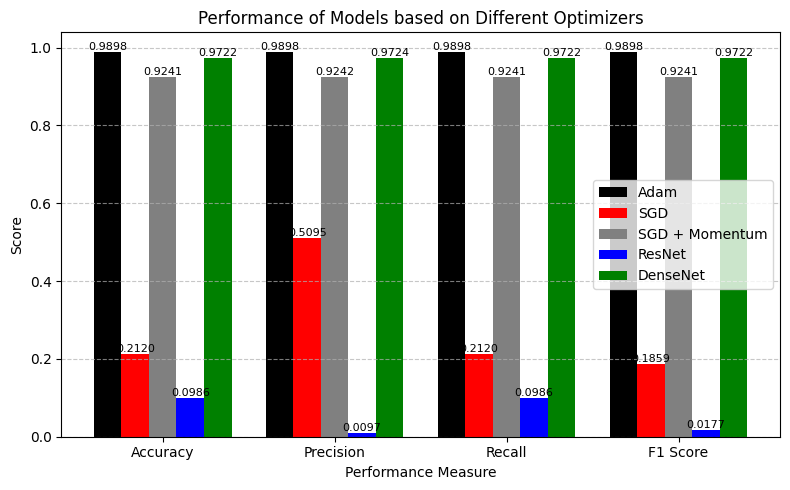

In [23]:
plot_optimizer_performance([performance,sgd_performance,sgdm_performance,resnet_performance, densenet_performance], ['Adam','SGD','SGD + Momentum','ResNet', 'DenseNet'])


Clearing up the memory.